# Load models

In [1]:
import warnings
warnings.filterwarnings("ignore") 
import copy
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.base import BaseEstimator, ClassifierMixin
import torch
import torch.nn.functional as F
from torch import nn
from torch.nn import Linear
from torch_geometric.data import DataLoader, Data, InMemoryDataset
from torch_geometric.nn import (GCNConv, GATConv, DeepGraphInfomax, SAGEConv,
                                DenseGraphConv, GINEConv, APPNP, LEConv)
from torch_geometric.nn import (global_mean_pool, TopKPooling, SAGPooling,
                                GlobalAttention, BatchNorm, JumpingKnowledge)
from torch_geometric.utils import (dropout_adj, train_test_split_edges,
                                   add_remaining_self_loops, softmax,
                                   to_networkx, to_dense_batch, to_dense_adj,
                                   dense_to_sparse)
from functools import reduce
import tqdm


EPS = 1e-15

class NodeNorm(nn.Module): 
    # https://github.com/miafei/NodeNorm/blob/master/layers.py
    def __init__(self, unbiased=False, eps=1e-5):
        super(NodeNorm, self).__init__()
        self.unbiased = unbiased
        self.eps = eps

    def forward(self, x):
        mean = torch.mean(x, dim=1, keepdim=True)
        std = (torch.var(x, unbiased=self.unbiased, dim=1, keepdim=True) + self.eps).sqrt()
        x = (x - mean) / std
        return x


class GCNNet(torch.nn.Module): 
    def __init__(self, inp_dim, out_dim, hidden_topology=[32,64,128,128], p=0.5, p2=0.1, drop_each=True, attn_dropout=False, n_heads=1):
        super(GCNNet, self).__init__()
        self.out_dim=out_dim
        self.hidden_topology=hidden_topology
        self.norms=[]
        self.convs = nn.ModuleList([GATConv(inp_dim, hidden_topology[0], heads=n_heads, dropout=p*float(attn_dropout))]+[GATConv(n_heads*hidden_topology[i],hidden_topology[i+1], heads=n_heads, dropout=p*float(attn_dropout)) for i in range(len(hidden_topology[:-1]))])
        for i,conv in enumerate(self.convs):
            conv.reset_parameters()
            self.norms.append(BatchNorm(hidden_topology[i]*n_heads, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True))
        self.norms = nn.ModuleList(self.norms)
        self.drop_edge = lambda edge_index: dropout_adj(edge_index,p=p2)[0]
        self.dropout = nn.Dropout(p)
        self.fc = nn.Linear(hidden_topology[-1]*n_heads, out_dim)
        self.drop_each=drop_each

    def forward(self, x, edge_index, edge_attr=None):
        for i,conv in enumerate(self.convs):
            if self.drop_each and self.training: edge_index=self.drop_edge(edge_index)
            x = self.norms[i](F.relu(conv(x, edge_index, edge_attr)))
        if self.training:
            x = self.dropout(x)
        x = self.fc(x)
        return x,edge_index
    
class GCNFeatures(torch.nn.Module):
    def __init__(self, gcn, bayes=False):
        super(GCNFeatures, self).__init__()
        self.gcn=gcn
        self.drop_each=bayes
    
    def forward(self, x, edge_index, edge_attr=None):
        for i,conv in enumerate(self.gcn.convs):
            if self.drop_each: edge_index=self.gcn.drop_edge(edge_index)
            x = self.gcn.norms[i](F.relu(conv(x, edge_index, edge_attr)))
        if self.drop_each:
            x = self.gcn.dropout(x)
        y = self.gcn.fc(x)
        return x,y,edge_index
    

class WSG(torch.nn.Module):
    def __init__(self, inp_dim, n_hidden=32, n_layers=3, n_conv_block=3, p=0.5, p2=0.1, drop_each=True,n_out=2,dropout=0.4,ratio=0.5,min_score=None,attn_dropout=True,n_heads=1):# ratio 0.5
        super(WSG, self).__init__()
        if n_heads>1: n_heads=1
        self.conv1=GCNNet(inp_dim,n_hidden*n_heads,[n_hidden]*n_layers,p=p, p2=p2, drop_each=True, attn_dropout=True,n_heads=n_heads)
        self.convs=nn.ModuleList([GCNNet(n_hidden*n_heads, n_hidden*n_heads, hidden_topology=[n_hidden]*n_layers, p=p, p2=p2, drop_each=True, attn_dropout=True, n_heads=n_heads) for i in range(n_conv_block)])
        self.pools=nn.ModuleList([SAGPooling(n_hidden*n_heads,ratio=ratio,min_score=min_score) for i in range(n_conv_block)]) # dropout=dropout,
        self.mean_pool=lambda x,b: global_mean_pool(x,b)
        self.n_out=n_out
        self.fc=nn.Linear(n_hidden,n_out)#*(len(self.convs)+1)*n_heads
        self.attention = GlobalAttention(gate_nn=nn.Sequential(nn.Linear(n_hidden * n_heads, 1),
                                                                nn.Sigmoid()))
        
    def forward(self, x, edge_index, batch, edge_attr=None):
        x,edge_index=self.conv1(x,edge_index)
        xs=[self.mean_pool(x,batch)]
        perms=[]
        for conv,pool in zip(self.convs,self.pools):
            x,edge_index=conv(x,edge_index)
            x,edge_index, _, batch, perm, _=pool(x,edge_index,batch=batch)
        z=self.attention(x,batch)
        return z,self.fc((F.relu(z) if not self.training else self.conv1.dropout(F.relu(z)))),perms

class SHAP_GNN_GraphLevel(BaseEstimator, ClassifierMixin):
    def __init__(self, 
                 train_size=0.8, 
                 objective='class',
                use_weights=True,
                n_batches_backward=1,
                f1_metric='weighted',
                n_epochs=20,
                out_dir='gnn_models',
                lr=1e-3,
                eta_min=1e-4,
                T_max=20,
                wd=0,
                hidden_topology=[32,64,128,128],
                p=0.3,
                p2=0.3,
                burnin=400,
                warmup=100,
                gpu_id=0,
                n_conv_block=1,
                ratio=0.8,
                min_score=None,
                batch_size=128,
                verbose=False):
        assert objective=='class'
        self.train_size=train_size 
        self.objective=objective
        self.use_weights=use_weights
        self.n_batches_backward=n_batches_backward
        self.f1_metric=f1_metric
        self.n_epochs=n_epochs
        self.out_dir=out_dir
        self.lr=lr
        self.eta_min=eta_min
        self.T_max=T_max
        self.wd=wd
        self.hidden_topology=hidden_topology
        self.p=p
        self.p2=p2
        self.burnin=burnin
        self.warmup=warmup
        self.gpu_id=gpu_id
        self.n_conv_block=n_conv_block
        self.ratio=ratio
        self.min_score=min_score
        self.batch_size=batch_size
        self.verbose=verbose
        
    def fit(self, X,y,sample_weight=None, group_membership=None):
        assert sample_weight is None
        assert group_membership is None
        train_data,val_data,y_train,y_val=train_test_split(X,y,train_size=0.5,stratify=y,random_state=42)
            
        if self.use_weights: 
            weights=compute_class_weight(
                class_weight = "balanced",
                classes = np.unique(y),
                y = y_train)
        else: 
            weights=None

        self.model=WSG(train_data[0].x.shape[1],  
                        n_hidden=self.hidden_topology[0], 
                        n_layers=len(self.hidden_topology), 
                        n_conv_block=self.n_conv_block, 
                        p=self.p, 
                        p2=self.p2, 
                        drop_each=True,
                        n_out=len(np.unique(y)),
                        dropout=self.p,
                        ratio=self.ratio,
                        min_score=self.min_score)
        if torch.cuda.is_available(): self.model=self.model.cuda()

        # load optimizer
        self.optimizer = torch.optim.Adam(self.model.parameters(),lr=self.lr,weight_decay=self.wd)
        self.scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(self.optimizer, self.T_max, eta_min=self.eta_min, last_epoch=-1)
        if self.use_weights:
            weights=torch.tensor(weights).float()
            if torch.cuda.is_available(): weights=weights.cuda()
        else: weights=None
        self.criterion=nn.CrossEntropyLoss(weight=weights)
        if torch.cuda.is_available(): self.criterion=self.criterion.cuda()

        # initialize val saving
        save_mod=True
        past_performance=[0]
        best_model_dict=copy.deepcopy(self.model.state_dict())

        # dataloaders
        dataloaders={}

        dataloaders['train']=DataLoader(train_data,batch_size=self.batch_size,shuffle=True)
        dataloaders['val']=DataLoader(val_data,batch_size=self.batch_size,shuffle=True)
        train_loader=dataloaders['train']

        n_total_batches=0
        train_val_auc=[]
        for epoch in tqdm.trange(self.n_epochs):
            Y,Y_Pred=[],[]
            Y2,Y_Pred2,Y_Pred3=[],[],[]
            self.model.train(True)
            for i,data in enumerate(train_loader):
                n_total_batches+=1
                x=data.x
                y=data.y
                edge_index=data.edge_index
                batch=data.batch
                if torch.cuda.is_available():
                    x=x.cuda()
                    edge_index=edge_index.cuda()
                    y=y.cuda()
                    batch=batch.cuda()
                y=y.long()
                y_pred=self.model(x,edge_index,batch)[1]
                loss = self.criterion(y_pred, y) / self.n_batches_backward
                loss.backward()
                if n_total_batches%self.n_batches_backward==0 or (i==len(train_loader.dataset)-1):
                    self.optimizer.step()
                    self.optimizer.zero_grad()
                Y_Pred.append(F.softmax(y_pred).detach().cpu().numpy())
                Y.append(y.detach().cpu().numpy().flatten())
                del x, edge_index, loss
            Y,Y_Pred=np.hstack(Y),np.vstack(Y_Pred)
            train_auc=roc_auc_score(Y,Y_Pred if Y_Pred.shape[1]>2 else Y_Pred[:,1],average='macro',multi_class='ovr')
            self.scheduler.step()
            self.model.train(False)

            with torch.no_grad():
                for k in ['val']:
                    Y,Y_Pred,Z=[],[],[]
                    for i,data in enumerate(dataloaders[k]):
                        x=data.x
                        y=data.y
                        edge_index=data.edge_index
                        batch=data.batch
                        if torch.cuda.is_available():
                            x=x.cuda()
                            edge_index=edge_index.cuda()
                            y=y.cuda()
                            batch=batch.cuda()
                        y=y.long()
                        z_out,y_pred,perm=self.model(x,edge_index,batch)
                        y_pred_proba=F.softmax(y_pred).detach().cpu().numpy()
                        y_true=data.y.numpy().flatten()
                        Y.append(y_true)
                        Y_Pred.append(y_pred_proba)
                        Z.append(z_out.detach().cpu().numpy())
                        del x, edge_index, z_out, y_pred_proba
                    Y_true,Y_Pred=np.hstack(Y),np.vstack(Y_Pred)
                   
                    val_auc=roc_auc_score(Y_true,Y_Pred if Y_Pred.shape[1]>2 else Y_Pred[:,1],average='macro',multi_class='ovr')
                    if save_mod and val_auc>=max(past_performance):
                        best_model_dict=copy.deepcopy(self.model.state_dict())
                    past_performance.append(val_auc)
            if self.verbose: print(train_auc,val_auc)
        
        print(f"Top AUC: {max(past_performance)}")
        self.model.load_state_dict(best_model_dict)
        self.past_performance=past_performance
        return self

    def predict_proba(self,X):
        dataloaders={}
        dataloaders['test']=DataLoader(X,batch_size=128,shuffle=False)
        with torch.no_grad():
            for k in ['test']:
                Y,Y_Pred,Z=[],[],[]
                for i,data in enumerate(dataloaders[k]):
                    x=data.x
                    y=data.y
                    edge_index=data.edge_index
                    batch=data.batch
                    if torch.cuda.is_available():
                        x=x.cuda()
                        edge_index=edge_index.cuda()
                        y=y.cuda()
                        batch=batch.cuda()
                    z_out,y_pred,perm=self.model(x,edge_index,batch)
                    y_pred_proba=F.softmax(y_pred).detach().cpu().numpy()
                    y_true=data.y.numpy().flatten()
                    Y.append(y_true)
                    Y_Pred.append(y_pred_proba)
                    Z.append(z_out.detach().cpu().numpy())
                    del x, edge_index, z_out, y_pred_proba
                Y_true=np.hstack(Y)
                return np.vstack(Y_Pred)

    def predict(self,X):
        return self.predict_proba(X).argmax(1)
        
        
class SHAP_GNN_NodeLevel(BaseEstimator, ClassifierMixin):
    def __init__(self, 
                 train_size=0.8, 
                 objective='class',
                use_weights=True,
                n_batches_backward=1,
                f1_metric='weighted',
                n_epochs=20,
                out_dir='gnn_models',
                lr=1e-3,
                eta_min=1e-4,
                T_max=20,
                wd=0,
                hidden_topology=[32,64,128,128],
                p=0.3,
                p2=0.3,
                burnin=400,
                warmup=100,
                gpu_id=0,
                n_conv_block=1,
                ratio=0.8,
                min_score=None,
                batch_size=128,
                verbose=False):
        assert objective=='class'
        self.train_size=train_size 
        self.objective=objective
        self.use_weights=use_weights
        self.n_batches_backward=n_batches_backward
        self.f1_metric=f1_metric
        self.n_epochs=n_epochs
        self.out_dir=out_dir
        self.lr=lr
        self.eta_min=eta_min
        self.T_max=T_max
        self.wd=wd
        self.hidden_topology=hidden_topology
        self.p=p
        self.p2=p2
        self.burnin=burnin
        self.warmup=warmup
        self.gpu_id=gpu_id
        self.n_conv_block=n_conv_block
        self.ratio=ratio
        self.min_score=min_score
        self.batch_size=batch_size
        self.verbose=verbose
        
    def fit(self, X,y,sample_weight=None, group_membership=None):
        assert sample_weight is None
        assert group_membership is None
        train_data,val_data,y_train,y_val=train_test_split(X,y,train_size=0.8,random_state=42)
        y=list(reduce(lambda x,y:(x)+(y),y))
            
        y_train=list(reduce(lambda x,y:(x)+(y),y_train))

        if self.use_weights: 
            weights=compute_class_weight(
                class_weight = "balanced",
                classes = np.unique(y_train),
                y = y_train)
        else: 
            weights=None

        self.model=GCNNet(train_data[0].x.shape[1], len(np.unique(y)), 
                          hidden_topology=self.hidden_topology, 
                          p=self.p, 
                          p2=self.p2)
        if torch.cuda.is_available(): self.model=self.model.cuda()

        self.optimizer = torch.optim.Adam(self.model.parameters(),lr=self.lr,weight_decay=self.wd)
        self.scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(self.optimizer, self.T_max, eta_min=self.eta_min, last_epoch=-1)
        if self.use_weights:
            weights=torch.tensor(weights).float()
            if torch.cuda.is_available(): weights=weights.cuda()
        else: weights=None
        self.criterion=nn.CrossEntropyLoss(weight=weights)
        if torch.cuda.is_available(): self.criterion=self.criterion.cuda()

        save_mod=True
        past_performance=[0]
        best_model_dict=copy.deepcopy(self.model.state_dict())

        dataloaders={}

        dataloaders['train']=DataLoader(train_data,batch_size=self.batch_size,shuffle=True)
        dataloaders['val']=DataLoader(val_data,batch_size=self.batch_size,shuffle=True)
        train_loader=dataloaders['train']

        n_total_batches=0
        train_val_auc=[]
        for epoch in tqdm.trange(self.n_epochs):
            Y,Y_Pred=[],[]
            Y2,Y_Pred2,Y_Pred3=[],[],[]
            self.model.train(True)
            for i,data in enumerate(train_loader):
                n_total_batches+=1
                x=data.x
                y=data.y
                edge_index=data.edge_index
                batch=data.batch
                if torch.cuda.is_available():
                    x=x.cuda()
                    edge_index=edge_index.cuda()
                    y=y.cuda()
                    batch=batch.cuda()
                y=y.long()
                y_pred=self.model(x,edge_index)[0]
                y[-1] = 1
                loss = self.criterion(y_pred, y) / self.n_batches_backward
                loss.backward()
                if n_total_batches%self.n_batches_backward==0 or (i==len(train_loader.dataset)-1):
                    self.optimizer.step()
                    self.optimizer.zero_grad()
                Y_Pred.append(F.softmax(y_pred,dim=1).detach().cpu().numpy())
                Y.append(y.detach().cpu().numpy().flatten())
                del x, edge_index, loss
            Y_true,Y_Pred=np.hstack(Y),np.vstack(Y_Pred)
            train_auc=roc_auc_score(Y_true,Y_Pred if Y_Pred.shape[1]>2 else Y_Pred[:,1],average='macro',multi_class='ovr')
            self.scheduler.step()
            self.model.train(False)

            with torch.no_grad():
                for k in ['val']:
                    Y,Y_Pred,Z=[],[],[]
                    for i,data in enumerate(dataloaders[k]):
                        x=data.x
                        y=data.y
                        edge_index=data.edge_index
                        batch=data.batch
                        if torch.cuda.is_available():
                            x=x.cuda()
                            edge_index=edge_index.cuda()
                            y=y.cuda()
                            batch=batch.cuda()
                        y=y.long()
                        y_pred=self.model(x,edge_index)[0]
                        y_pred_proba=F.softmax(y_pred,dim=1).detach().cpu().numpy()
                        y_true=data.y.numpy().flatten()
                        Y.append(y_true)
                        Y_Pred.append(y_pred_proba)
                        del x, edge_index, y_pred_proba
                    Y_true,Y_Pred=np.hstack(Y),np.vstack(Y_Pred)
                    val_auc=roc_auc_score(Y_true,Y_Pred if Y_Pred.shape[1]>2 else Y_Pred[:,1],average='weighted',multi_class='ovr')

                    if save_mod and val_auc>=max(past_performance):
                        best_model_dict=copy.deepcopy(self.model.state_dict())
                    past_performance.append(val_auc)

            if self.verbose: print(train_auc,val_auc)
        self.past_performance=past_performance
        self.model.load_state_dict(best_model_dict)
        print(f"Top AUC: {max(past_performance)}")
        return self

    def predict_proba(self,X):
        dataloaders={}
        dataloaders['test']=DataLoader(X,batch_size=128,shuffle=False)
        with torch.no_grad():
            for k in ['test']:
                Y,Y_Pred,Z=[],[],[]
                for i,data in enumerate(dataloaders[k]):
                    x=data.x
                    y=data.y
                    edge_index=data.edge_index
                    batch=data.batch
                    if torch.cuda.is_available():
                        x=x.cuda()
                        edge_index=edge_index.cuda()
                        y=y.cuda()
                        batch=batch.cuda()
                    y_pred=self.model(x,edge_index)[0]
                    y_pred_proba=F.softmax(y_pred,dim=1).detach().cpu().numpy()
                    y_true=data.y.numpy().flatten()
                    Y.append(y_true)
                    Y_Pred.append(y_pred_proba)
                    del x, edge_index, y_pred_proba
                Y_true=np.hstack(Y)
                return np.vstack(Y_Pred)

    def predict(self,X):
        return self.predict_proba(X).argmax(1)


# Load data and plot

In [9]:
lymphocyte_data=pd.read_pickle('lymphocyte_toy_data.pkl')

In [10]:
lymphocyte_data.keys()

dict_keys(['ims', 'X', 'y', 'X_graph', 'y_graph'])

(-0.5, 255.5, 255.5, -0.5)

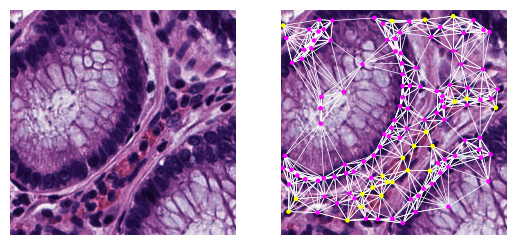

In [4]:
import matplotlib.pyplot as plt
idx=31
plt.subplot(121)
plt.imshow(lymphocyte_data["ims"][idx])
plt.axis("off")
plt.subplot(122)
plt.imshow(lymphocyte_data["ims"][idx])
for i,j in lymphocyte_data["X"][idx].edge_index.T:
    plt.plot([lymphocyte_data["X"][idx]["pos"][i,0],lymphocyte_data["X"][idx]["pos"][j,0]],[lymphocyte_data["X"][idx]["pos"][i,1],lymphocyte_data["X"][idx]["pos"][j,1]],c="white",lw=.5,zorder=1)
plt.scatter(*lymphocyte_data["X"][idx]["pos"].numpy().T.tolist(),c=lymphocyte_data["X"][idx]["y"].numpy(),cmap="spring",s=5)
plt.axis("off")

# Node Classification
Identify whether cell is tagged with CD45:

In [5]:
sgnn=SHAP_GNN_NodeLevel(lr=1e-2,n_epochs=100,burnin=0,warmup=0,eta_min=1e-6, hidden_topology=[32,32], T_max = 60, n_batches_backward=1).fit(lymphocyte_data["X"],lymphocyte_data["y"])


100%|██████████| 100/100 [00:08<00:00, 12.38it/s]

Top AUC: 0.6339383381762633


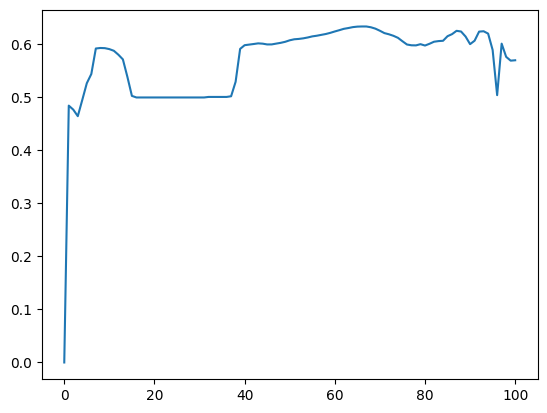

In [6]:
plt.plot(sgnn.past_performance)

# Graph level classification
Are the number of immune cells at least 50% per image?

In [7]:
sgnn=SHAP_GNN_GraphLevel(lr=1e-3,n_epochs=100,burnin=0,warmup=0,ratio=0.75, eta_min=1e-6, hidden_topology=[32,32], T_max = 60, n_batches_backward=1).fit(lymphocyte_data["X_graph"],lymphocyte_data["y_graph"])


100%|██████████| 100/100 [00:09<00:00, 10.07it/s]

Top AUC: 0.76


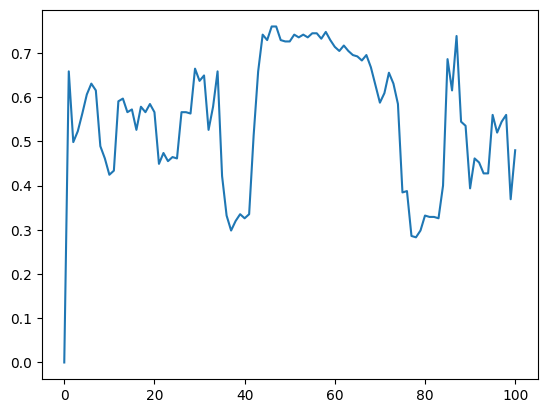

In [8]:
plt.plot(sgnn.past_performance)

# Task: Lookup GNNExplainer and other explanation methods
e.g., https://pytorch-geometric.readthedocs.io/en/latest/tutorial/explain.html 